# UJM - Master DSC/MLDM - Deep Learning - TP2b - GANs

## Part . GAN (Generative Adversarial Network)



The following code is from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [3]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import sys
import numpy as np


**Build the Generator**

In [4]:
noise_shape = (100,)
img_shape = (28,28,1)

with tf.device("/GPU:0"):
  model = Sequential()
  model.add(Dense(256, input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(784, activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape=noise_shape)
  img = model(noise)

  generator =  Model(inputs = noise, outputs = img)

  optimizer = Adam(0.0002, 0.5)
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

**Build the Discriminator**

In [5]:

with tf.device("/GPU:0"):
  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  discriminator =  Model(inputs = img, outputs = validity)
  discriminator.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

**Combine Generator and Discriminator**

In [6]:
z = Input(shape=(100,))
img = generator(z)

# we will only train the generator when we run the combined model
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


**Function to print out images**

In [7]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

In [8]:
# Include the epoch in the file name (uses `str.format`)
import os; import tensorflow as tf
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 128

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

In [ ]:

#Uncomment the below code for loading the weights of a saved model.
# discriminator.load_weights('./saves/discriminator_9000')
# combined.load_weights('./saves/combined_9000')

**Train the model.** Note: If you rerun the model, it will continue with the left off weights. To train from scratch, please recompile your model.

0 [D loss: 0.708374, acc.: 52.34%] [G loss: 0.830538]


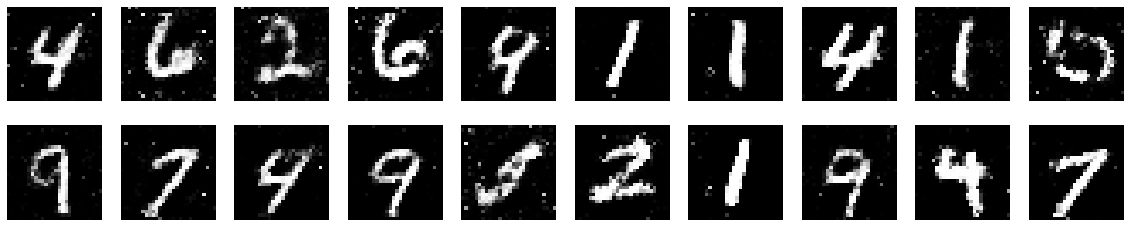

1000 [D loss: 0.711509, acc.: 46.88%] [G loss: 0.815737]


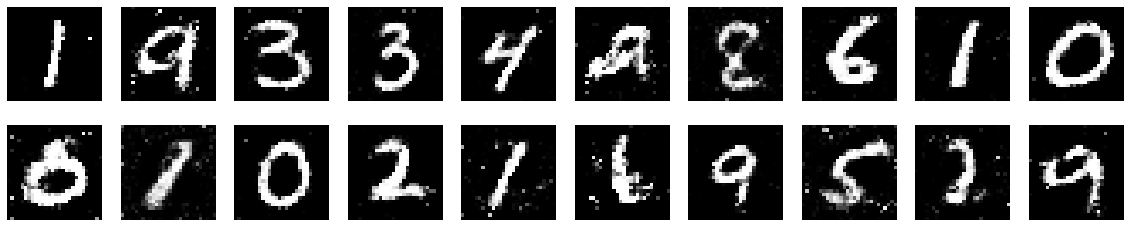

2000 [D loss: 0.718231, acc.: 42.97%] [G loss: 0.827298]


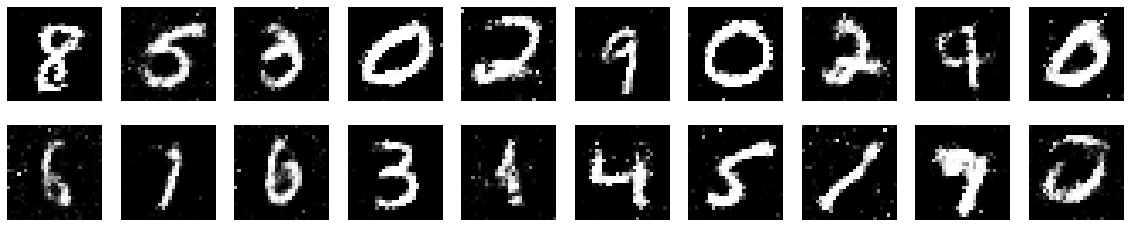

KeyboardInterrupt: ignored

In [12]:
epochs = 10000
batch_size = 128
print_interval = 1000
save_every = 1000

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

half_batch = int(batch_size / 2)

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    # Saving the model for every 1000 epochs
    if epoch % save_every == 0:
      discriminator_path = './saves/discriminator_'+str(epoch)
      combined_path = './saves/combined_'+str(epoch)
      discriminator.save_weights(discriminator_path)
      combined.save_weights(combined_path)

    if epoch % print_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 
                                                               100*d_loss[1], g_loss))
        print_imgs()

### Exercise 1. GAN for CIFAR-10

Modify the code above to train on CIFAR-10.

In [10]:
from keras.datasets import cifar10

epochs = 20000
batch_size = 128
save_interval = 2000

# Load the dataset
(X_train, _), (_, _) = cifar10.load_data()


#Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5


half_batch = int(batch_size / 2)

#Create lists for logging the losses
d_loss_logs_r = []
d_loss_logs_f = []
g_loss_logs = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    # ....

    

SyntaxError: ignored

### Exercise 2 - try to use convolutional GAN

In [ ]:
##